In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.mesh as mesh
import tensorflow as tf
from PIL import Image
from pyeit.mesh.shape import thorax
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2023-11-03 14:49:44.057155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_reconstruction(mesh_obj, ds, title="reconstruction"):
    el_pos = np.arange(tmp["n_el"])
    pts = mesh_obj.node
    tri = mesh_obj.element
    x, y = pts[:, 0], pts[:, 1]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    im = ax.tripcolor(x, y, tri, ds, shading="flat")
    for i, e in enumerate(el_pos):
        ax.annotate(str(i + 1), xy=(x[e], y[e]), color="r")
    ax.set_aspect("equal")
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlim([-1.2, 1.2])
    fig.set_size_inches(6, 6)

![gif](../codes/breathing.gif)

In [3]:
l_path = "../data_thorax/h0=0.05_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=Truendiv=2/"

In [4]:
tmp = np.load(l_path + "sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

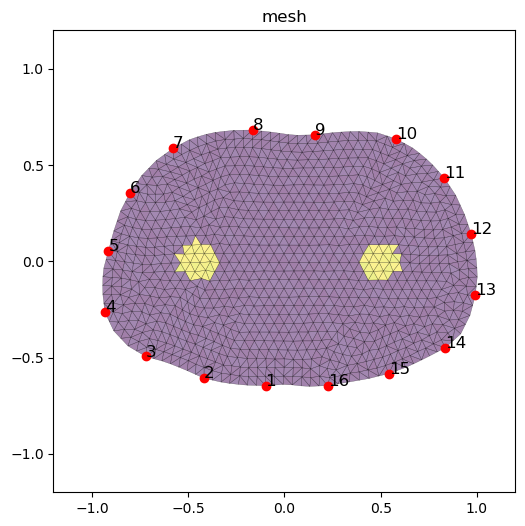

In [5]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"], fd=thorax)
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [6]:
V = list()
radii = list()
perms = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    V.append(tmp_l["v_obj"])
    radii.append(tmp_l["anomaly"][0].r)
    perms.append(tmp_l["perm_array"])

V = np.array(V)
perms = np.array(perms) #/ 25  # DIVIDED BY 15 FOR VAE RANGE
radii = np.array(radii)

100%|██████████| 10000/10000 [00:30<00:00, 325.11it/s]


In [7]:
tt_spl = 8000
V_train = V[:tt_spl]
V_test = V[tt_spl:]
perms_train = perms[:tt_spl]
np.random.shuffle(perms_train)
perms_test = perms[tt_spl:]
radii_train = radii[:tt_spl]
radii_test = radii[tt_spl:]

In [8]:
perms_train = perms[:tt_spl]

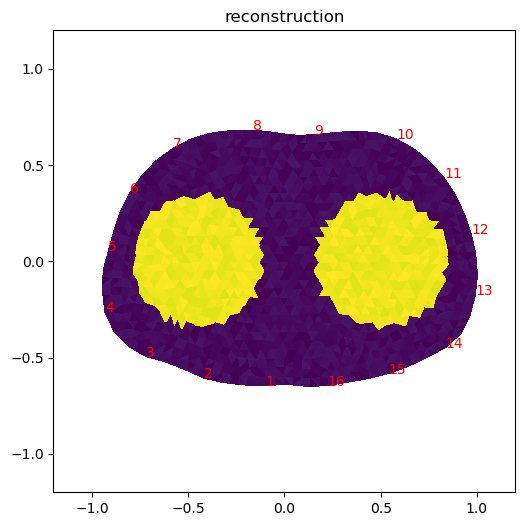

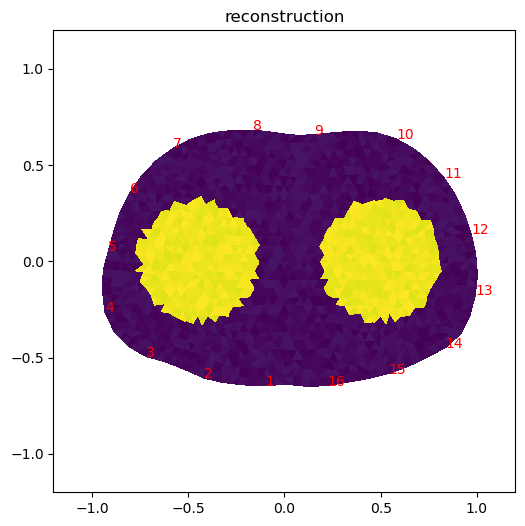

In [9]:
plot_reconstruction(mesh_obj, perms_train[0] )
plot_reconstruction(mesh_obj, perms_train[1] )

## Build VAE

In [32]:
from VAE import vae

In [11]:
vae.compile(Adam(), loss=tf.losses.mean_squared_error)
history = vae.fit(perms_train, epochs=20, batch_size=32)

Epoch 1/20


2023-11-03 14:51:01.588640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-03 14:51:02.415739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-03 14:51:02.714561: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f35ff62ec50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 14:51:02.714615: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-03 14:51:02.714625: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-03 14:51:02.737232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-03 14:51:02.92412

250/250 [==============================] - 13s 14ms/step - loss: 13.3529 - reconstruction_loss: 8.7746 - kl_loss: 0.3447
Epoch 2/20
250/250 [==============================] - 4s 14ms/step - loss: 5.1155 - reconstruction_loss: 3.9158 - kl_loss: 0.8530
Epoch 3/20
250/250 [==============================] - 4s 14ms/step - loss: 4.1971 - reconstruction_loss: 2.9818 - kl_loss: 1.1165
Epoch 4/20
250/250 [==============================] - 4s 14ms/step - loss: 3.5573 - reconstruction_loss: 2.1726 - kl_loss: 1.2247
Epoch 5/20
250/250 [==============================] - 4s 14ms/step - loss: 3.2423 - reconstruction_loss: 1.8771 - kl_loss: 1.2865
Epoch 6/20
250/250 [==============================] - 4s 14ms/step - loss: 3.0620 - reconstruction_loss: 1.7123 - kl_loss: 1.3420
Epoch 7/20
250/250 [==============================] - 4s 14ms/step - loss: 2.9475 - reconstruction_loss: 1.5722 - kl_loss: 1.3709
Epoch 8/20
250/250 [==============================] - 4s 14ms/step - loss: 2.9340 - reconstruction_

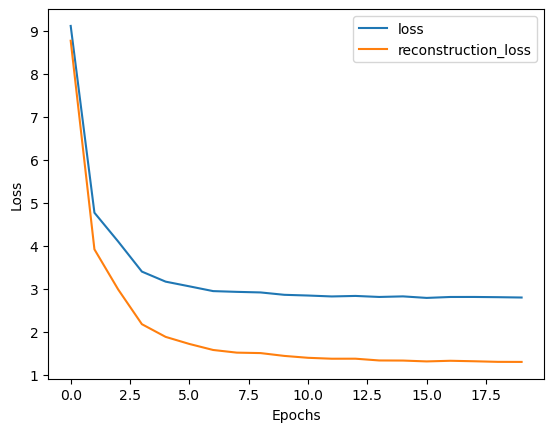

In [36]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
perms = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    perms.append(tmp_l["perm_array"])

perms = np.array(perms) #/ 25  # DIVIDED BY 15 FOR VAE RANGE

100%|██████████| 10000/10000 [00:18<00:00, 533.23it/s]


1/1 [==============================] - 0s 26ms/step


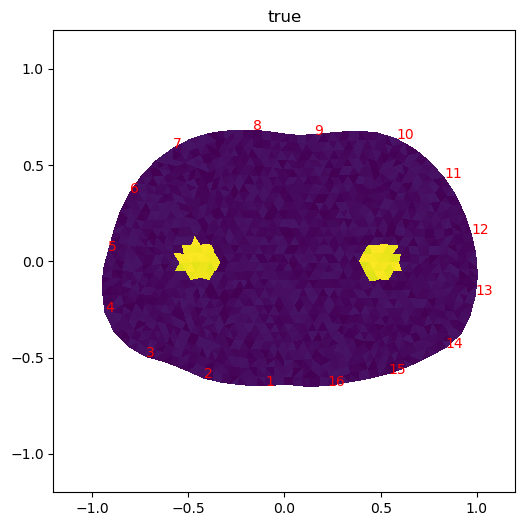

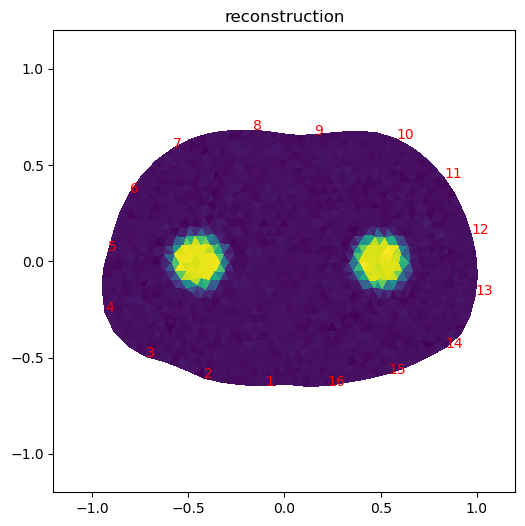

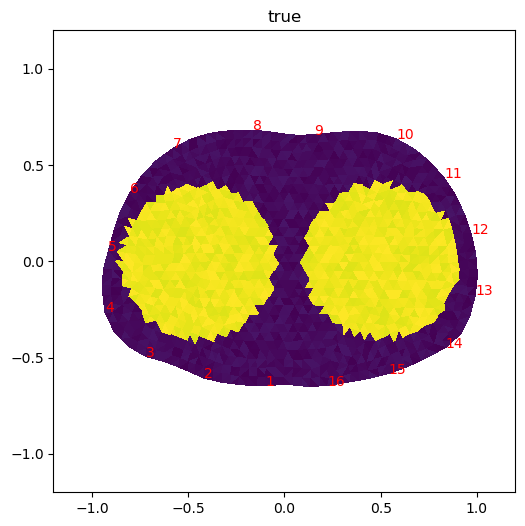

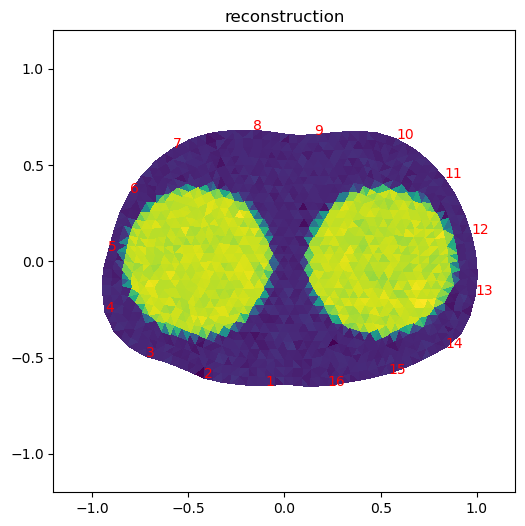

In [38]:
# reset order to default
perms_train = perms[:tt_spl]
_, _, z0 = vae.encoder.predict(np.expand_dims(perms_train[0, :], 0))
_, _, z50 = vae.encoder.predict(np.expand_dims(perms_train[50, :], 0))

plot_reconstruction(mesh_obj, perms_train[0, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z0)))
plot_reconstruction(mesh_obj, perms_train[50, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z50)))

In [39]:
train_z_mean, train_z_log_var, train_z = vae.encoder.predict(perms_train)
test_z_mean, test_z_log_var, test_z = vae.encoder.predict(perms_test)
all_z_mean, all_z_log_var, all_z = vae.encoder.predict(perms)

313/313 [==============================] - 1s 3ms/step


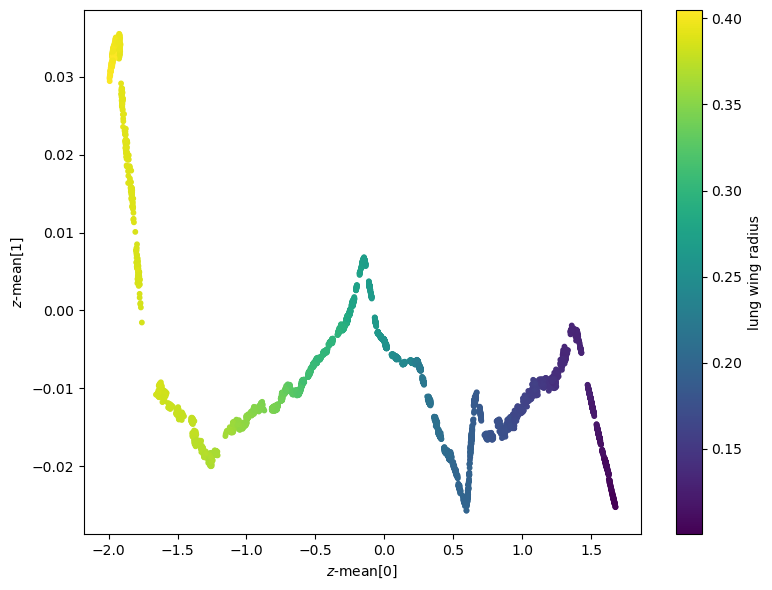

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(train_z_mean[:, 0], train_z_mean[:, 1], c=radii_train, s=10)
plt.xlabel("$z$-mean[0]")
plt.ylabel("$z$-mean[1]")
# plt.axis('off')
plt.tight_layout()
# plt.savefig("../../beauty_of_latent_spaces/1.pdf")
plt.colorbar(label="lung wing radius")
plt.show()

In [41]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
#latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data
latent_space_2d = tsne.fit_transform(all_z)  # latent data

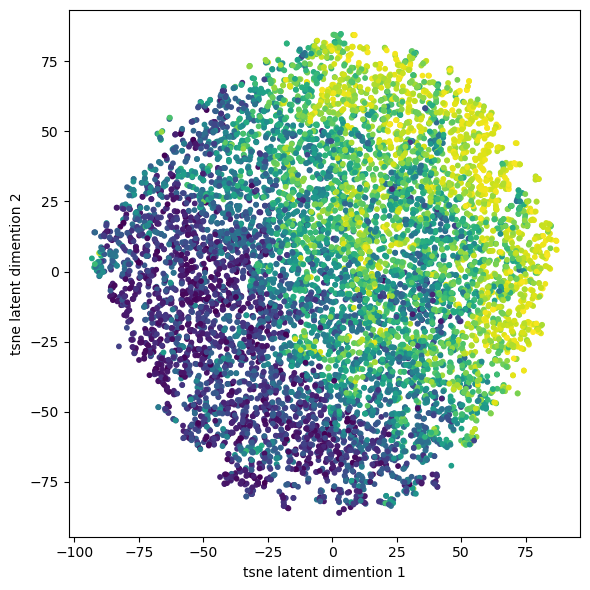

In [42]:
plt.figure(figsize=(6, 6))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=radii, s=10)
plt.xlabel("tsne latent dimention 1")
plt.ylabel("tsne latent dimention 2")
# plt.colorbar(label="lung wing radius")
# plt.grid()
plt.tight_layout()
#plt.savefig("../../beauty_of_latent_spaces/5.pdf")
plt.show()

## Mapper with LSTM

In [43]:
nseg = 4

X = [V_train[n : n + nseg, :] for n in range(V_train.shape[0] - nseg + 1)]
X = np.array(X)

Y_v = np.array(V_train[nseg - 1 :])

Y_perms = perms_train[nseg - 1 :]
_, _, Y = vae.encoder.predict(Y_perms)

250/250 [==============================] - 1s 3ms/step


In [44]:
print(X.shape, Y.shape)

(7997, 4, 192) (7997, 8)


In [47]:
np.allclose(X[0, nseg-1, :], Y_v[0, :])

True

In [48]:
def mapper_model(input_shape_lstm, nseg, input_shape_mapper, v_shape, latent_dim):
    def Slice(s):
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = layers.Dense(v_shape, activation="relu")
    inputs = layers.Input(shape=input_shape_lstm)
    con_list = []
    for s in range(nseg):
        x = layers.Lambda(Slice(s))(inputs)
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = layers.Concatenate(axis=1)(con_list)
    x = layers.Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = layers.LSTM(v_shape)(x)

    mapper_inputs = layers.Activation("softmax")(x)
    x = layers.Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
        activity_regularizer=regularizers.L2(1e-5),
    )(mapper_inputs)
    x = layers.Dense(64, activation="relu")(x)
    # x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    # x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(inputs, x)


mapper = mapper_model(
    input_shape_lstm=(nseg, 192),
    nseg=nseg,
    input_shape_mapper=(192,),
    v_shape=192,
    latent_dim=latent_dim,
)
mapper.compile(optimizer=Adam(), loss=tf.losses.mean_absolute_error)
mapper.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 192)]     0           []                               
                                                                                                  
 lambda (Lambda)                (None, 192)          0           ['input_3[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 192)          0           ['input_3[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 192)          0           ['input_3[0][0]']                
                                                                                              

2023-11-03 15:08:08.652676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-03 15:08:08.654287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-03 15:08:08.655240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [49]:
# Train X->Y

In [50]:
history = mapper.fit(
    X,
    Y,
    epochs=25,
    batch_size=64,
)

Epoch 1/25


2023-11-03 15:08:25.307676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-03 15:08:25.309404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-03 15:08:25.310477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - 4s 7ms/step - loss: 0.8078
Epoch 2/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7696
Epoch 3/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7672
Epoch 4/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7666
Epoch 5/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7660
Epoch 6/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7653
Epoch 7/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7653
Epoch 8/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7661
Epoch 9/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7647
Epoch 10/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7651
Epoch 11/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7650
Epoch 12/25
125/125 [==============================] - 1s 7ms/step - loss: 0.7643
Epoch 13/25
125/125 [===============

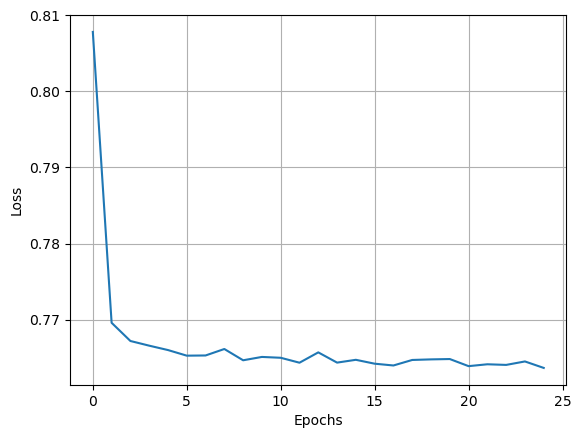

In [51]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [52]:
pred = mapper.predict(X)

 19/250 [=>............................] - ETA: 0s  

2023-11-03 15:08:52.828616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-03 15:08:52.830105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-03 15:08:52.831199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - 1s 3ms/step


In [53]:
Perm_pred = vae.decoder.predict(pred)

250/250 [==============================] - 1s 3ms/step


In [54]:
Perm_pred.shape

(7997, 1912)

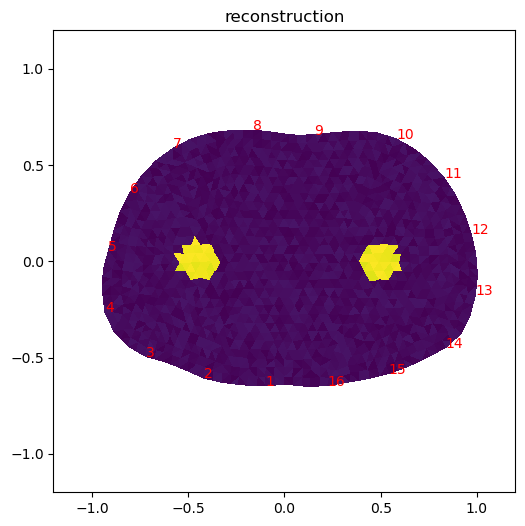

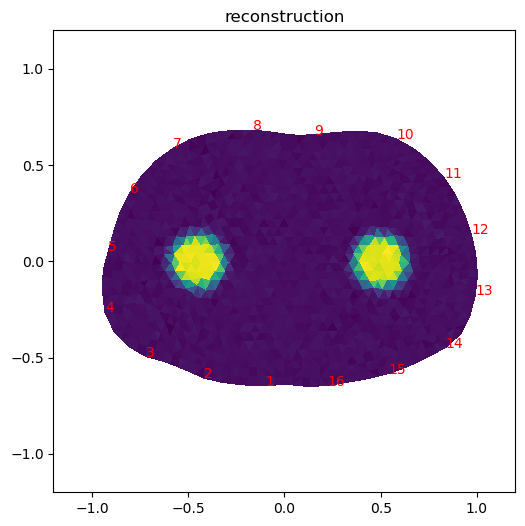

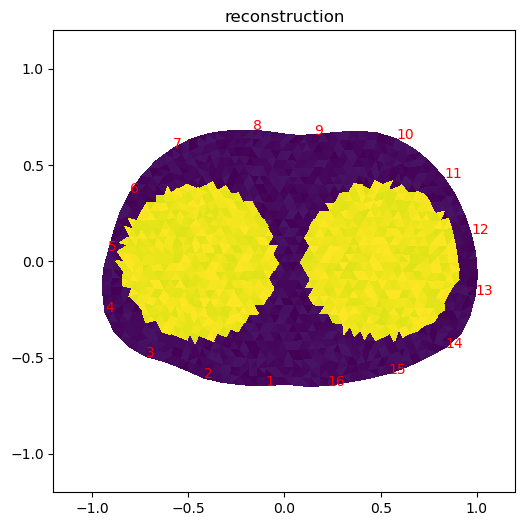

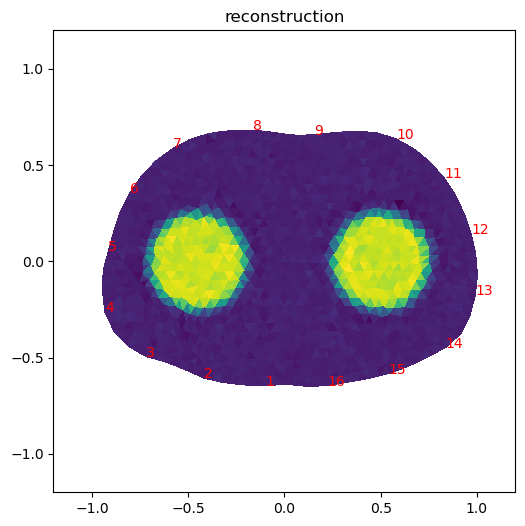

In [57]:
plot_reconstruction(mesh_obj, perms_train[0, :] * 15)
plot_reconstruction(mesh_obj, Perm_pred[0, :] * 15)
plot_reconstruction(mesh_obj, perms_train[50, :] * 15)
plot_reconstruction(mesh_obj, Perm_pred[50, :] * 15)

In [81]:
def perm_deviation(perm_true, perm_rec, brdr = 5):
    dev = len(np.argwhere(perm_true > brdr))-len(np.argwhere(perm_rec > brdr))
    return dev

In [82]:
perm_deviation(perms_train[0,:],Perm_pred[0,:])

-48

In [85]:
err = list()
for i in tqdm(range(Perm_pred.shape[0])):
    err.append(perm_deviation(perms_train[i,:],Perm_pred[i,:]))

100%|██████████| 7997/7997 [00:00<00:00, 41181.46it/s]


(array([2549., 1994.,  639.,  418.,  509.,  434.,  407.,  417.,  390.,
         240.]),
 array([-61.,   1.,  63., 125., 187., 249., 311., 373., 435., 497., 559.]),
 <BarContainer object of 10 artists>)

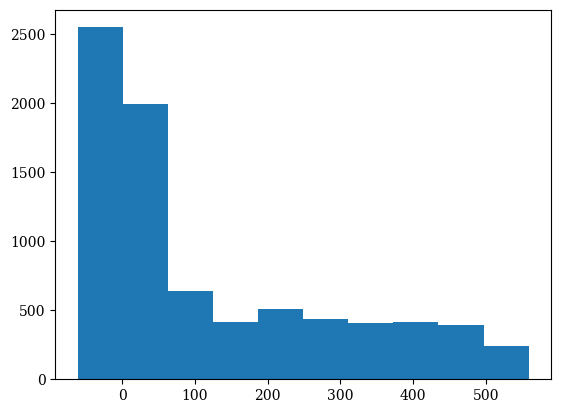

In [87]:
plt.hist(err)